# 1. Load Dataset

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml(name='mnist_784', as_frame=False)
mnist['data']

C:\Users\VICTUS\anaconda3\envs\deeplr\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [2]:
X, y = mnist.data, mnist.target

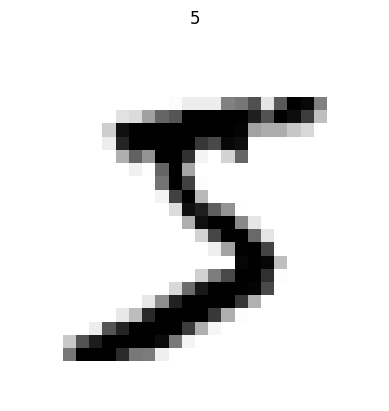

In [3]:
import matplotlib.pyplot as plt

def plot_digits(image, image_label):
    image = image.reshape(28,28)
    plt.imshow(image,cmap='binary')
    plt.axis("off")
    plt.title(image_label)

digit = X[0]
digit_label = y[0]

plot_digits(digit, digit_label)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [5]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

# 2. Training a Binary Classifier

**SGD(Stochastic Gradient Descent) Classifier** is capable of handling very large datasets efficiently.

In [6]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [8]:
sgd_clf.predict([X[0]])

array([ True])

array([False])

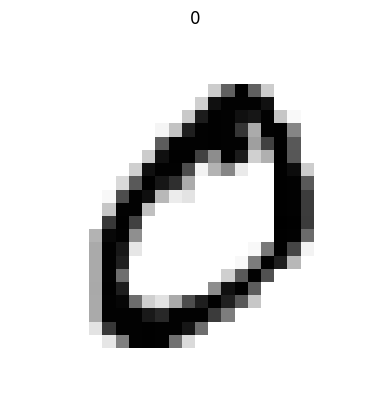

In [10]:
digit = X[1]
digit_label = y[1]

plot_digits(digit, digit_label)
sgd_clf.predict([X[1]])

# 3. Measuring Accuracy using Cross Validation


**Accuracy** is the % of correctly classified instances out of all the instances

$$ 
Accuracy = \frac{Number\ of\ Correct\ Predictions} {Total\ number\ of\ Predictions}
$$
<br><br>
$$
 Accuracy = \frac{(TP+TN)} {(TP+FP+TN+FN)}
$$

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, scoring='accuracy', cv=6)

array([0.96460623, 0.96027024, 0.97075729, 0.96853887, 0.96238403,
       0.96127471])

In [12]:
import pandas as pd
pd.DataFrame(y_train_5).value_counts()*100/len(y_train_5)

False    91.020168
True      8.979832
Name: count, dtype: float64

Around 91% is 'not 5' and remaining 9% 'is 5'.
If model always guess 'Not 5', accuracy will be 91%, this demonstrates why Accuracy is generally not the preferred performance measure for classifiers, especially when dealing with skewed/unbalanced dataset

In [13]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=6)

Cross-val predict performs K-fold cross validation, but instead of returning the evaluation score, it return the predictions made on each test fold

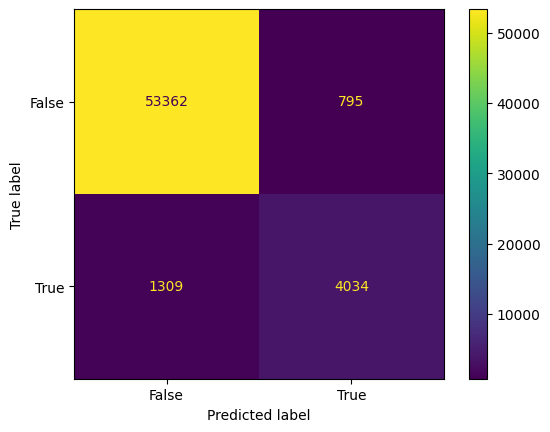

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train_5,y_train_pred)
ConfusionMatrixDisplay(cm, display_labels=sgd_clf.classes_,).plot()

- **Precision** is the percentage of true positive predictions out of all the positive predictions the model made.
$$
P = \frac {TP} {TP+FP}
$$
- **Recall** is the percentage of true positive predictions out of all the actual positive
$$
R = \frac {TP} {TP+FN}
$$
- **F1 Score** is the harmonic mean of precision and recall, providing a balance between the two.
$$
F1 = \frac {2*P*R} {P+R}
$$

In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f"Precision: {precision_score(y_train_5, y_train_pred)}")
print(f"Recall: {recall_score(y_train_5, y_train_pred)}")
print(f"F1-Score: {f1_score(y_train_5, y_train_pred)}")

Precision: 0.8353696417477738
Recall: 0.7550065506269886
F1-Score: 0.79315768777035


Increasing Precision reduces Recall and vice versa. This is called **precision/recall trade-off**.


**Summary:**  

- Accuracy: How often is the model correct?
- Precision: When the model predicts positive, how often is it right?
- Recall: How well does the model identify all actual positives?
- F1 Score: A single measure that balances precision and recall.

# 4. Precision/Recall trade-off

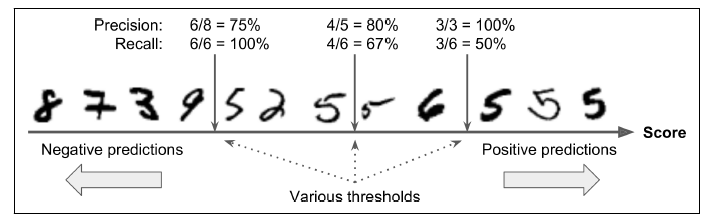
<br>
**The higher the threshold, lower the recall, but higher the precision**

Scikit-Learn does not let set the threshold directly, but it does give access to the decision scores that it uses to make predictions. 
Instead of calling the classifier’s predict() method, you can call its decision_function() method, which returns a score for each instance, and then make predictions based on those scores using any threshold you want:

In [14]:
y_scores = sgd_clf.decision_function([digit])
y_scores

array([3156.6703652])

In [16]:
threshold = 0
y_digit_pred = (y_scores > threshold)
y_digit_pred

array([ True])

The SGDClassifier uses a threshold equal to 0, so the previous code returns the same result as the predict() method (i.e., True). 
Let’s raise the threshold:

In [17]:
threshold = 3200
y_digit_pred = (y_scores > threshold)
y_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents
a 5, and the classifier detects it when the threshold is 0, but it misses it when the
threshold is increased to 3200

##### Now how do you decide which threshold to use? 
For this you will first need to get the
scores of all instances in the training set using the cross_val_predict() function
again, but this time specifying that you want it to return decision scores instead of
predictions:

#### 4.1 Precision-Recall vs. Threshold

In [20]:
from sklearn.model_selection import cross_val_predict
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=6, method='decision_function')

In [19]:
from sklearn.metrics import precision_recall_curve
# Precision Recall curve function can be used to compute precision, recall for all possible thresholds
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [31]:
thresholds[0]

-85765.40548556745

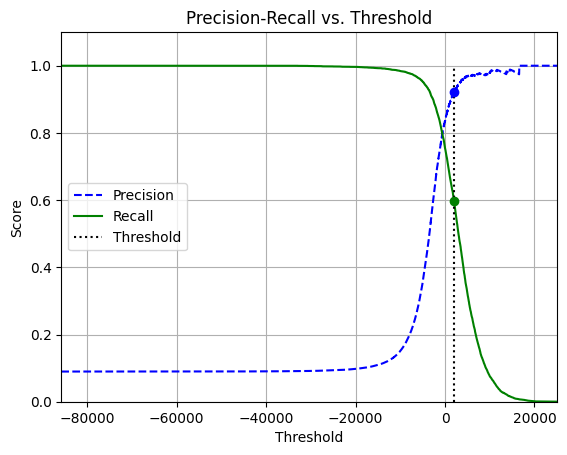

In [39]:
import numpy as np
def find_nearest(array, value):
    """Helper function to find the index of the nearest value in an array."""
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, threshold=3000):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.vlines(threshold, 0, 1.0, "k", "dotted", label='Threshold')
    plt.legend(['Precision','Recall','Threshold'])
    #[...] # highlight the threshold, axis label and grid
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.grid(True)
    plt.title('Precision-Recall vs. Threshold')
    plt.ylim([0, 1.1])  # Adjust the y-axis limits as needed
    plt.xlim([min(thresholds), max(thresholds)])

    # Highlight the point where threshold intersects with precision and recall
    idx = find_nearest(thresholds, threshold)
    plt.plot(threshold, precisions[idx], 'bo')
    plt.plot(threshold, recalls[idx], 'go')

plot_precision_recall_vs_threshold(precisions, recalls, thresholds,2000)
plt.show()

#### 4.2 PR Curve

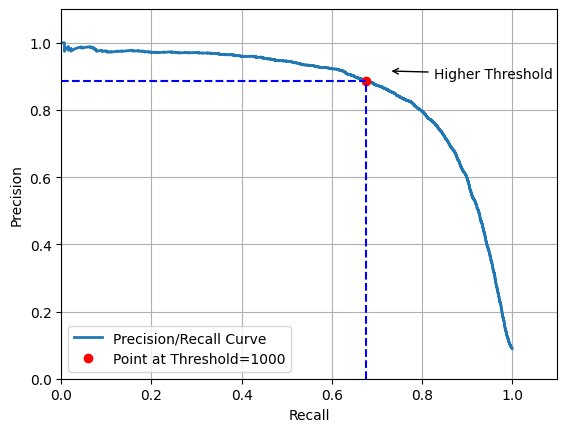

In [75]:
def PR_Curve(precisions, recalls, thresholds, threshold=3000):
    plt.xlim([0,1.1])
    plt.ylim([0,1.1])
    plt.plot(recalls, precisions, linewidth=2, label='Precision/Recall Curve')
    idx = find_nearest(thresholds, threshold)
    plt.plot(recalls[idx],precisions[idx], 'ro')
    plt.plot([0,recalls[idx]],[precisions[idx], precisions[idx]], 'b--')
    plt.plot(
        [ recalls[idx], recalls[idx] ],
        [ 0, precisions[idx] ],
        'b--'
    )
    arrow_properties = dict(facecolor='blue', arrowstyle='->')
    plt.annotate('Higher Threshold', xy=(recalls[idx]+0.05, precisions[idx]+0.03), xytext=(recalls[idx]+0.15, precisions[idx]+0.01), arrowprops=arrow_properties)
    plt.grid(True)
    plt.legend(['Precision/Recall Curve',f'Point at Threshold={threshold}'], loc='lower left')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

PR_Curve(precisions, recalls, thresholds, threshold=1000)
plt.show()

* We can see that precision really starts to fall sharply around 80% recall. 
* We may want to select a precision/recall tradeoff just before that drop—for example, at around 70% recall. But of course the choice depends on project.

So let’s suppose you decide to aim for 90% precision. You look up the first plot and
find that you need to use a threshold of about 8,000. To be more precise you can
search for the lowest threshold that gives you at least 90% precision (np.argmax()
will give us the first index of the maximum value, which in this case means the first
True value):

In [76]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

1335.9790931665334

In [78]:
# To make predictions (on the training set for now), instead of calling the classifier’s predict() method, you can just run this code:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([ True, False, False, ..., False, False, False])

In [79]:
precision_score(y_train_5, y_train_pred_90)

0.9001814882032668

In [80]:
recall_score(y_train_5, y_train_pred_90)

0.6498221972674527

**Note:** A high precision classifier is not very useful if its recall is too low. If someone says `"Let's reach 99% Precision"`. `"You should ask at what recall?"`

#### 4.3 ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with
binary classifiers. It is very similar to the precision/recall curve, but instead of plotting
precision versus recall, the ROC curve plots the true positive rate (another name
for recall) against the false positive rate. The FPR is the ratio of negative instances that
are incorrectly classified as positive. It is equal to one minus the true negative rate,
which is the ratio of negative instances that are correctly classified as negative. The
TNR is also called specificity. Hence the ROC curve plots sensitivity (recall) versus
1 – specificity.

In [81]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

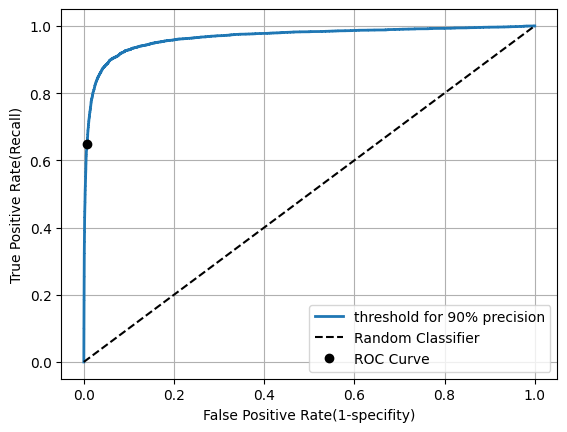

In [90]:
def plot_roc_curve(fpr, tpr, tpr90=None, fpr90=None):
    plt.plot(fpr, tpr, linewidth=2, label='ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--',label='Random Classifier') # dashed diagonal
    if tpr90 is not None and fpr90 is not None:
        plt.plot([fpr90],[tpr90],'ko', label='threshold for 90% precision')
    plt.grid(True)
    plt.xlabel('False Positive Rate(1-specifity)')
    plt.ylabel('True Positive Rate(Recall)')
    plt.legend(['threshold for 90% precision', 'Random Classifier', 'ROC Curve'])
    #[...] # Add axis labels and grid

idx_for_threshold_at_90 = (thresholds <= threshold_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
plot_roc_curve(fpr, tpr, tpr_90, fpr_90)
plt.show()

One way to compare classifiers is to measure the area under the curve (AUC). A perfect
classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC
AUC:

In [87]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9664336589886514

As a rule of thumb, you should `prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives`, `Otherwise use the ROC curve`.

#### 4.4 Let’s train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier.

In [88]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=6,method="predict_proba")

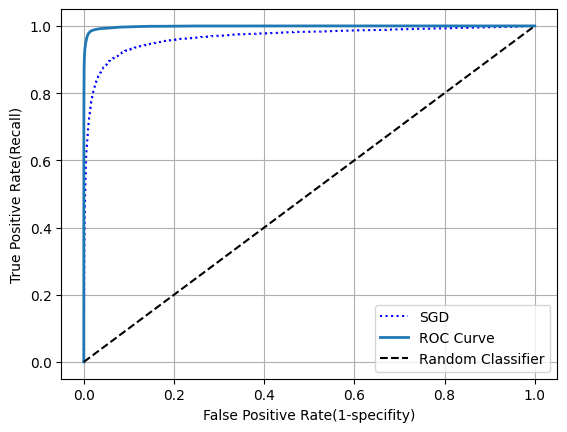

In [91]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

the RandomForestClassifier’s ROC curve looks much
better than the SGDClassifier’s: it comes much closer to the top-left corner. As a
result, its ROC AUC score is also significantly better:

In [92]:
roc_auc_score(y_train_5, y_scores_forest)

0.9985383354433113

# 5. Multiclass Classification
#### Distinguish between more than 2 classes

- Some scikit learn classifiers are capable of handling multiple classes natively (e.g. LogisticRegression, RandomForestClassifier and GaussianNB)
- Others are strictly binary classifiers. (e.g. SGDClassifier and SVC)
- There are various strategies to perform multiclass classification with multiple binary classifier
    - `One-versus-the-rest (OvR)` 10 binary classifier for each digit. Selects the class whose classifier outputs the highest score
    - `One-versus-one (OvO)` Train binary classifier for each pair of digits: 0s and 1s, 0s and 2s and so on. Selects the class which wins most duels. Its main advantage is it is trained on part of training data set containing the 2 classes it must distinguish.\
        - Some Algo like SVM scale poorly with the size of training data. OvO is preferred for them.

In [21]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [30]:
i = 5
digit, digit_label = X[i], y[i]
print(f"Actual Digit: {digit_label} Predicted: {svm_clf.predict([digit])}")
svm_clf.decision_function([digit]).round(2)

Actual Digit: 2 Predicted: ['2']


array([[ 2.78, -0.29,  9.3 ,  2.88,  4.8 ,  3.83,  0.75,  6.15,  6.24,
         8.25]])

`Decision function shows it returns 10 scores per instance: one per class. Ecah class gets a score equal to number of won duels plus or minus a smalll tweak`

- If you want to force scikit learn to use one-versus-one or one-versus-the-rest you can use sklearn.multiclass's OneVsOneClassifier or OneVsRestClassifier.

# 6. MultiLabel Classification

- Want you classifier to output multiple classes for each instance
- Recognize 3 faces in image: Alice, bob and Charlie, it should output [True, False, True]

In [31]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train>'7') # Whether digit is Larger than 7
y_train_odd = (y_train.astype('int8')%2==1) # Whether digit is odd

y_multilabel = np.c_[y_train_large, y_train_odd]

In [32]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [40]:
i = 0
digit, digit_label = X[i], y[i]
print(f"Actual Digit: {digit_label} Predicted: {knn_clf.predict([digit])}")

Actual Digit: 5 Predicted: [[False  True]]


- The digit 5 is not large(False) and odd(True)

In [42]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9709335491382767

- Not all classifiers support multilabel classification. 
- Scikit-learn has a class called Chain Classifier that does just that. 
- It uses the input feature plus the prediction of the models that come before it in the chain. 

In [43]:
from sklearn.multioutput import ClassifierChain
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [45]:
i = 0
digit, digit_label = X[i], y[i]
print(f"Actual Digit: {digit_label} Predicted: {chain_clf.predict([digit])}")

Actual Digit: 5 Predicted: [[0. 1.]]
